In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df_combine = pd.read_csv('../crawl/data/clean/df_combine.csv')
# Ensure 'Date' is in datetime format
df_combine['Date'] = pd.to_datetime(df_combine['Date'])
df = df_combine[df_combine['Date'] < '2024-01-01']
df

,Date,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,unemploy_rate_us,unemploy_rate_vn,fdi_vn,fdi_us
0,2018-01-01,22625.0,22655.0,22735.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
1,2018-01-02,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2,2018-01-03,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
3,2018-01-04,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
4,2018-01-05,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
...,...,...,...,...,...,...,...,...,...,...
2185,2023-12-27,24110.0,24140.0,24480.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4
2186,2023-12-28,24030.0,24060.0,24400.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4
2187,2023-12-29,24050.0,24080.0,24420.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4
2188,2023-12-30,24050.0,24080.0,24420.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4


## Table of Contents
* [1. Forex Data](#1)
    * [Section 1.1](#section_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)

### **1. Forex Data <a class="anchor" id="1"></a>**

In [12]:
df['Sell'].describe()

count     2190.000000
mean     23372.473059
std        460.501878
min      22720.000000
25%      23120.000000
50%      23270.000000
75%      23530.000000
max      25481.000000
Name: Sell, dtype: float64

- The interquartile range (IQR), which is the difference between the 75th and 25th percentiles, is 410 (23.530 - 23.120). This indicates the middle 50% of the data is concentrated within this range, showing moderate variability.
- The close proximity of the median (23.270) to the mean (23.372,47) suggests a relatively symmetrical distribution of exchange rates, though the presence of outliers (as indicated by the min and max values) could skew the distribution slightly.

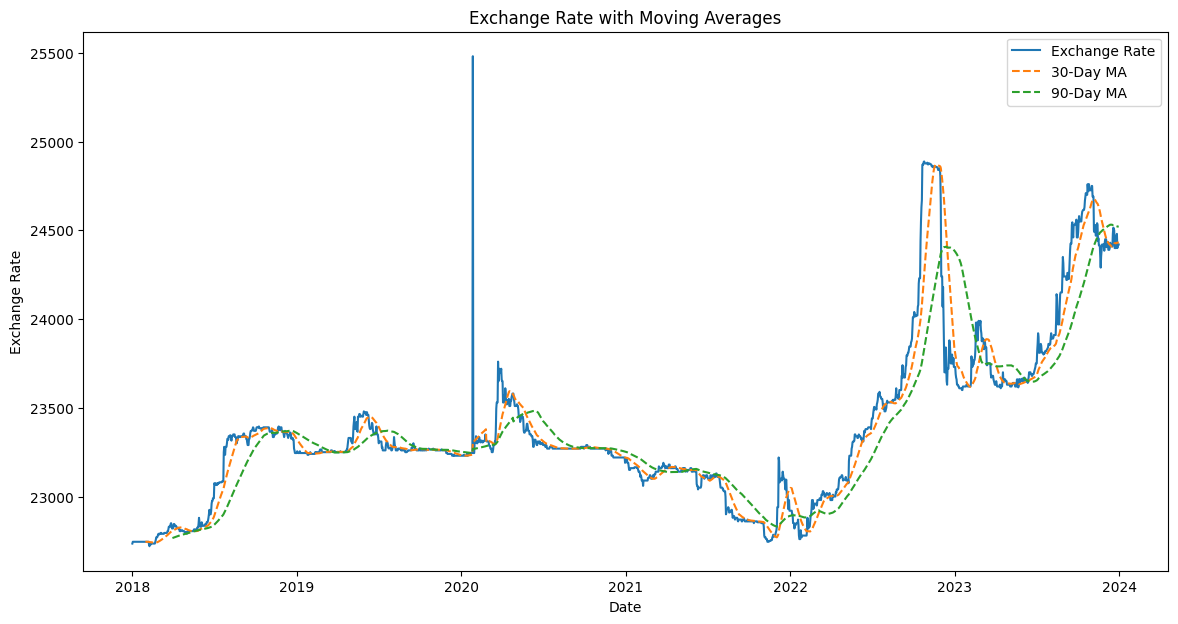

In [15]:
# Plot moving averages plot
df_tmp = df.copy()
df_tmp['MA30'] = df['Sell'].rolling(window=30).mean()
df_tmp['MA90'] = df['Sell'].rolling(window=90).mean()

plt.figure(figsize=(14, 7))
plt.plot(df_tmp['Date'], df_tmp['Sell'], label='Exchange Rate')
plt.plot(df_tmp['Date'], df_tmp['MA30'], label='30-Day MA', linestyle='--')
plt.plot(df_tmp['Date'], df_tmp['MA90'], label='90-Day MA', linestyle='--')
plt.title('Exchange Rate with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

- From the beginning of the series (2018) to the end (2024), the exchange rate has experienced several significant fluctuations.
- There is a notable upward trend starting around early 2022, indicating a general increase in the exchange rate over this period.


In [ ]:
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
df_tmp.set_index('Date', inplace=True)

Any time series distribution has 3 core components:
1. Seasonality - does the data have a clear cyclical/periodic pattern?
2. Trend - does the data represent a general upward or downward slope?
3. Noise - what are the outliers or missing values that are not consistent with the rest of the data?

<Axes: xlabel='Date'>

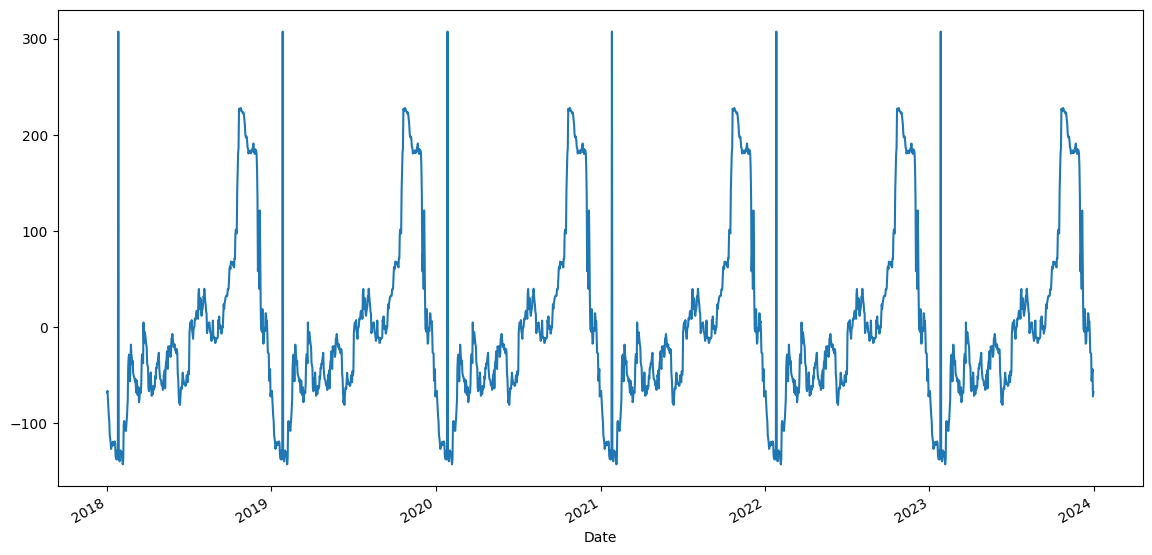

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import rcParams

result = seasonal_decompose(df_tmp['Sell'], model='additive', period=365)
rcParams["figure.figsize"] = 14, 7
result.seasonal.plot()

<Axes: xlabel='Date'>

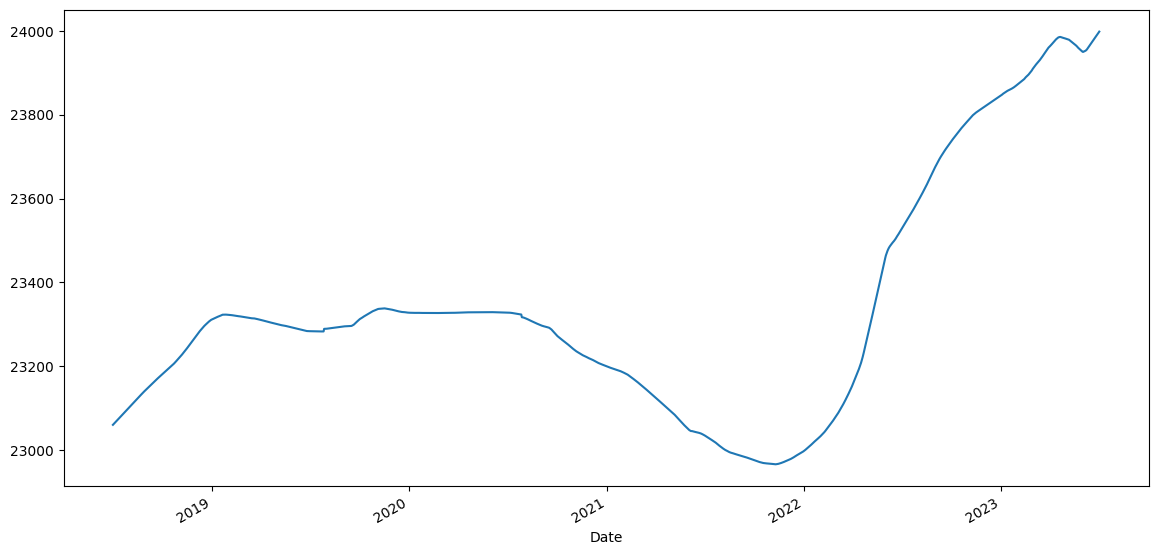

In [36]:
result.trend.plot()